In [1]:
from collections import defaultdict

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from pysida.scripts.f_compute_texture import Runner as RunnerTextures
from pysida.liblkf import Rasterizer


In [2]:
pfile = '../../../rgps/csv/w07_may_pairs.npz'
date_begin = datetime(2007, 1, 1)
date_end = datetime(2007, 1, 5)


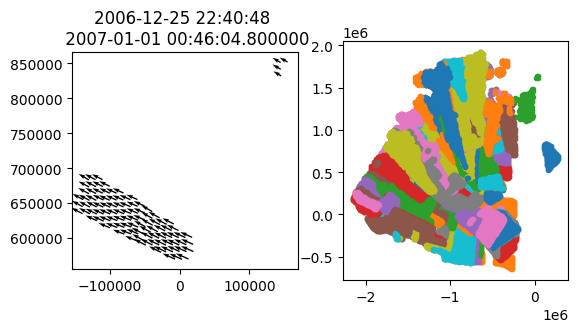

In [3]:
# show content of Pairs file
with np.load(pfile, allow_pickle=True) as f:
    pairs = f['pairs']

p = pairs[0]
fig, axs = plt.subplots(1, 2)
axs[0].quiver(p.x0, p.y0, p.x1 - p.x0, p.y1 - p.y0)
axs[0].set_title(f'{p.d0} \n {p.d1}')

for p in pairs:
    if date_begin <= p.d0 <= date_end:
        axs[1].plot(p.x0, p.y0, '.')
for ax in axs:
    ax.set_aspect('equal')
plt.show()

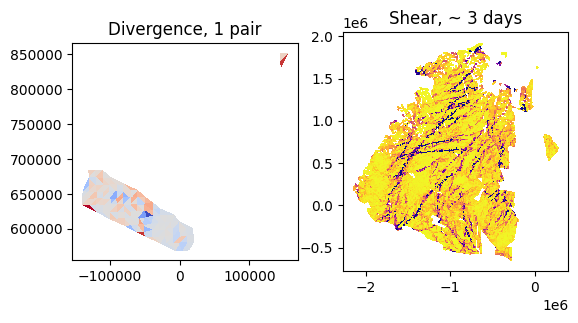

In [4]:
# show content of deformation file
dfile = pfile.replace('_pairs.npz', '_defor.npz')
with np.load(dfile, allow_pickle=True) as f:
    defor = f['defor']

p = pairs[0]
d = defor[0]
fig, axs = plt.subplots(1, 2)
axs[0].tripcolor(p.x0, p.y0, p.t, d.e1, mask=~p.g, cmap='coolwarm')

for p, d in zip(pairs, defor):
    if date_begin <= p.d0 <= date_end:
        axs[1].tripcolor(p.x0, p.y0, p.t, d.e2 * 24 * 60 * 60, mask=~p.g, cmap='plasma_r', vmin=0, vmax=0.1)
for ax in axs:
    ax.set_aspect('equal')
axs[0].set_title('Divergence, 1 pair')
axs[1].set_title('Shear, ~ 3 days')

plt.show()

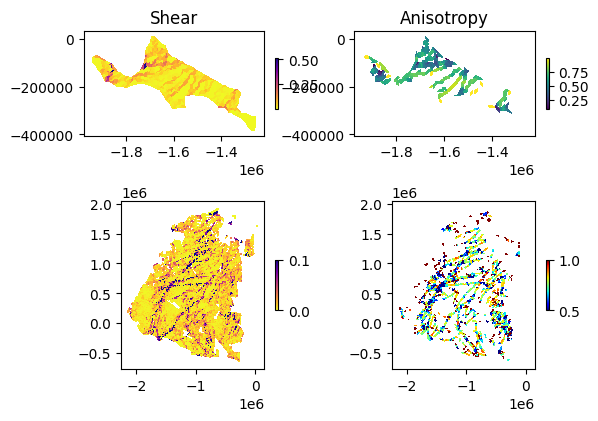

In [5]:
# show contents of anisotropy file
afile = pfile.replace('_pairs.npz', '_aniso.npz')
with np.load(afile, allow_pickle=True) as f:
    aniso = list(f['aniso'])


# index of an example pair with many deformation observations
i = 39
# example distance at which anisotropy is computed
s = 6

p, d, a = pairs[i], defor[i], aniso[i]
ani = a[f'ani|{s}']
idx = a[f'idx|{s}']
fig, axs = plt.subplots(2, 2)
trp0 = axs[0, 0].tripcolor(p.x0, p.y0, p.t[p.g], d.e2[p.g] * 24 * 60 * 60, cmap='plasma_r')
trp1 = axs[0, 1].tripcolor(p.x0, p.y0, p.t[p.g][idx], ani)
axs[0, 0].set_title('Shear')
axs[0, 1].set_title('Anisotropy')

for p, d, a in zip(pairs, defor, aniso):
    ani = a[f'ani|{s}']
    idx = a[f'idx|{s}']
    if date_begin <= p.d0 <= date_end and len(ani) > 0:
        trp2 = axs[1, 0].tripcolor(p.x0, p.y0, p.t, d.e2 * 24 * 60 * 60, mask=~p.g, cmap='plasma_r', vmin=0, vmax=0.1)
        trp3 = axs[1, 1].tripcolor(p.x0, p.y0, p.t[p.g][idx], ani, cmap='jet', vmin=0.5, vmax=1.0)

for ax in axs.flat:
    ax.set_aspect('equal')
plt.colorbar(trp0, ax=axs[0, 0], shrink=0.3)
plt.colorbar(trp1, ax=axs[0, 1], shrink=0.3)
plt.colorbar(trp2, ax=axs[1, 0], shrink=0.3)
plt.colorbar(trp3, ax=axs[1, 1], shrink=0.3)

plt.show()


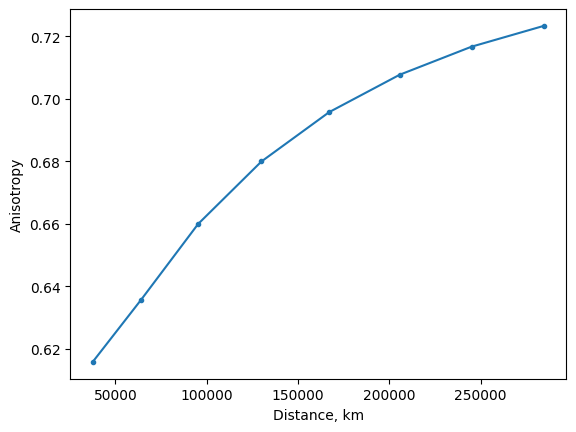

In [6]:
# plot average Anisotropy spectrum
ani_scale = defaultdict(list)
siz_scale = defaultdict(list)

scales = range(2, 10)
for p, a in zip(pairs, aniso):
    if date_begin <= p.d0 <= date_end:
        for s in scales:
            ani = a[f'ani|{s}']
            siz = a[f'siz|{s}']
            if len(ani) > 0:
                ani_scale[s].extend(list(ani))
                siz_scale[s].extend(list(siz))

ani_avg = np.array([np.mean(ani_scale[s]) for s in scales])
siz_avg = np.array([np.mean(siz_scale[s]) for s in scales])

plt.plot(siz_avg / 1e3, ani_avg, '.-')
plt.xlabel('Distance, km')
plt.ylabel('Anisotropy')
plt.show()

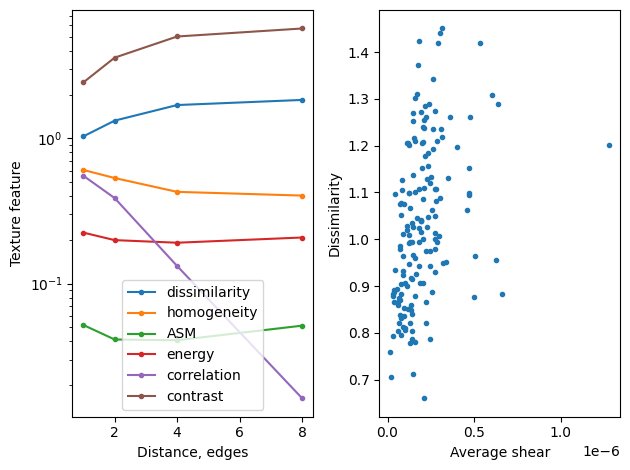

In [7]:
# show content of texture features files
tfile = '../../../rgps/csv/w07_may_texture.npz'
with np.load(tfile, allow_pickle=True) as f:
    props = f['props']


props_date = []
x0avgs = []
y0avgs = []
e2_avgs = []

for p, d, t in zip(pairs, defor, props):
    if t[0, -1] == 0:
        t[:, -1] = np.nan
    if date_begin <= p.d0 <= date_end:
        props_date.append(t)
        e2_avgs.append(np.nanmean(d.e2[p.g]))
props_date = np.dstack(props_date)
props_avg = np.nanmean(props_date, axis=2)

fig, axs = plt.subplots(1, 2)
for i, name in enumerate(RunnerTextures.propnames):
    axs[0].semilogy([1,2,4,8], props_avg[i], '.-', label=name)
axs[0].legend()
axs[0].set_xlabel('Distance, edges')
axs[0].set_ylabel('Texture feature')

axs[1].plot(e2_avgs, props_date[0,0], '.')
axs[1].set_xlabel('Average shear')
axs[1].set_ylabel('Dissimilarity')
plt.tight_layout()
plt.show()

2007-01-01 00:00:00


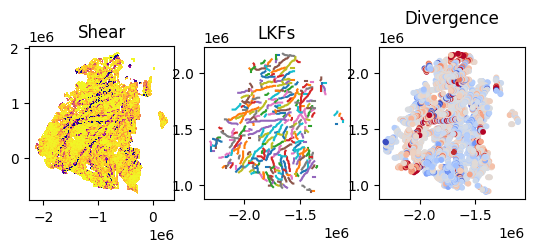

In [8]:
ra = Rasterizer()

lfile  = '../../../rgps/csv/w07_may_lkfs.npz'
with np.load(lfile, allow_pickle=True) as f:
    lkfs_defs = f['lkfs_defs']
    lkf_dates = f['dates']

lkfi = 0
print(lkf_dates[lkfi])
lkfs, defs = lkfs_defs[lkfi]

fig, axs = plt.subplots(1, 3)

for p, d in zip(pairs, defor):
    if date_begin <= p.d0 <= date_end:
        axs[0].tripcolor(p.x0, p.y0, p.t, d.e2 * 24 * 60 * 60, mask=~p.g, cmap='plasma_r', vmin=0, vmax=0.1)

for (r,c), e1 in zip(lkfs, defs[0]):
    x = ra.x_grd[r, c]
    y = ra.y_grd[r, c]
    axs[1].plot(x, y, '-')
    axs[2].scatter(x, y, 10, e1, vmin=-0.04, vmax=0.04, cmap='coolwarm')


for ax in axs:
    ax.set_aspect('equal')

axs[0].set_title('Shear')
axs[1].set_title('LKFs')
axs[2].set_title('Divergence')
plt.show()


Text(0, 0.5, 'Average conjugate fault intersection angle')

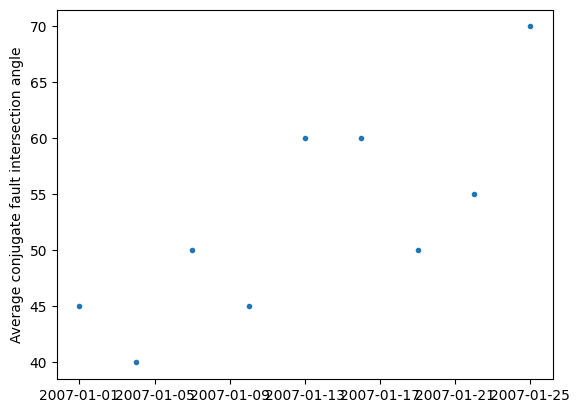

In [9]:
lsfile = '../../../rgps/csv/w07_may_lkf_stats.npz'
with np.load(lsfile, allow_pickle=True) as f:
    lkf_stats = f['lkf_stats'].item()
plt.plot(lkf_stats['dates'], lkf_stats['angles'], '.')
plt.ylabel('Average conjugate fault intersection angle')